# Transfer learning

In [1]:
import os
from IPython.display import display, clear_output
import shutil
import random
from tqdm import tqdm
import pickle as pk

import pandas as pd
import numpy as np

from PIL import Image
import torch
from torch import nn
from torchvision import transforms
from torchvision import datasets
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Make train and test directories

In [2]:
# Create train and test folders
for train_test_dir in ['train/','test/']:
    try:
        os.mkdir('data/'+train_test_dir)
    except:
        pass

In [3]:
# Define training and test data directories
data_dir = 'data/'
dataset_dir = os.path.join(data_dir, 'dataset/')
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

In [4]:
for subdir in tqdm(os.listdir(dataset_dir)):
    l = os.listdir(dataset_dir+subdir)
    train, test, _ , _ = train_test_split(l,[subdir for i in range(len(l))],test_size=0.2, random_state=42)
    
    # Create subdirectories in test and train folders
    for train_test_dir in ['train/','test/']:
        try:
            os.mkdir('data/'+train_test_dir+subdir)
        except:
            pass
    
    # Populate train and test folders
    for item in [dataset_dir+subdir+'/'+f for f in train] :
        shutil.copy(item, train_dir+subdir)

    for item in [dataset_dir+subdir+'/'+f for f in test] :
        shutil.copy(item, test_dir+subdir)

100%|████████████████████████████████████████████████████████████████████████████████| 145/145 [02:05<00:00,  1.15it/s]


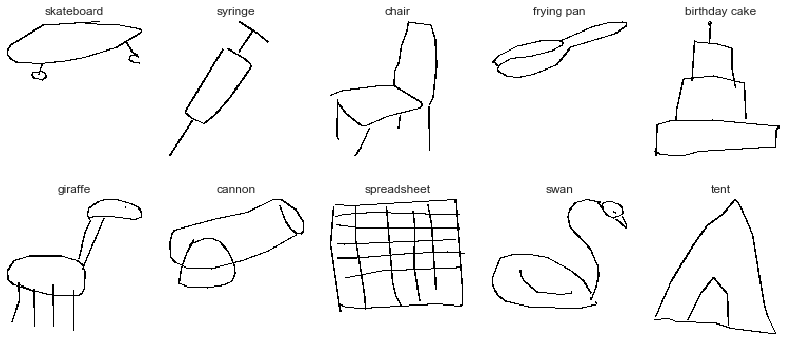

In [11]:
fig,ax = plt.subplots(figsize=(14,6))

lines=2
cols=5
i=1

# sample from train dir
for i in range(1,11):
    rd_dir = random.sample(os.listdir(train_dir),1)[0]
    sample = random.sample(os.listdir(train_dir+rd_dir),1)[0]
    im = Image.open(train_dir+rd_dir+'/'+sample)
    plt.subplot(lines,cols,i)
    plt.imshow(np.asarray(im))
    plt.axis('off')
    plt.title(rd_dir)
    i+=1

### Extract features out of convolutional layer

In [12]:
torch.multiprocessing.set_sharing_strategy('file_system')

# Load model
conv_layer = models.alexnet(pretrained=True)
print(conv_layer.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [13]:
# Image to tensor
def preprocess(img):  
    img = img.resize((224,224)).convert('RGB')
    tensor = transforms.ToTensor()(img)
    return tensor

# Load training data and fit to alexnet data
train = datasets.ImageFolder(train_dir, transform=preprocess)
test = datasets.ImageFolder(test_dir, transform=preprocess)

print('Num training images: ', len(train))
print('Num test images: ', len(test))

Num training images:  11600
Num test images:  2900


In [14]:
# generate data loaders
batch_size = 20
num_workers = 0
train_loader = torch.utils.data.DataLoader(train,batch_size=batch_size,shuffle=True,num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test,batch_size=batch_size,shuffle=True,num_workers=num_workers)

In [15]:
def extract_features(data_loader, output_path):
    
    num_batch = len(data_loader)
    count = 0
    try:
        os.remove(output_path) # to erase previous version as it is mode 'a'
    except FileNotFoundError:
        pass

    # extract features on a single line for each image
    for batch, labels in data_loader:

        feature_list = []
        label_list = []

        for idx, img in enumerate(batch):
            features_extracted = conv_layer.features(img.reshape((1, 3, 224, 224)))
            feature_list.append(features_extracted.detach().numpy().reshape((256 * 6 * 6)))
            label_list.append(labels[idx].item())

        row_features = pd.DataFrame(data=feature_list)
        row_label = pd.DataFrame(data=label_list, columns=['label'])
        row = pd.concat([row_features, row_label], axis=1)  
        row.to_csv(output_path, mode='a', header=not os.path.exists(output_path), index=False)
        count += 1

        # display progress
        clear_output(wait=True)
        file_size = os.path.getsize(output_path)
        print('batch %d/%d, %s file size: %.3f Mo'%(count, num_batch, output_path,  file_size/10**6))
        print('Forecasted csv size = %.2f Mo'%(num_batch/count*file_size/10**6))

In [16]:
%%time 
train_path = 'data/train_features.csv'
extract_features(train_loader, train_path)

batch 580/580, data/train_features.csv file size: 760.830 Mo
Forectased csv size = 760.83 Mo
Wall time: 40min 45s


In [17]:
%%time 
test_path = 'data/test_features.csv'
extract_features(test_loader, test_path)

batch 145/145, data/test_features.csv file size: 190.557 Mo
Forectased csv size = 190.56 Mo
Wall time: 10min 46s


## Train classifier

In [18]:
# Load datasets
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

X_train = np.array(train_df[train_df.columns[~train_df.columns.isin(['label'])]])
y_train = np.array(train_df['label'])
X_test = np.array(test_df[test_df.columns[~test_df.columns.isin(['label'])]])
y_test = np.array(test_df['label'])

In [19]:
# Size of sets
print("X Train set:",X_train.shape)
print("y Train set:",y_train.shape)
print("X Test set:",X_test.shape)
print("y Test set:",y_test.shape)

X Train set: (11600, 9216)
y Train set: (11600,)
X Test set: (2900, 9216)
y Test set: (2900,)


In [20]:
%%time
# Cross-validator 
sss = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2, random_state = 42)

# Define classifier
clf = RandomForestClassifier()

# definition of the pipeline
pipeline = Pipeline(steps = [
    ('RDF',clf)
])   

# parameters to tune (best parameters already known)
param_grid = {
    'RDF__n_estimators': [100],
    'RDF__max_depth': [None]
} 

# exhaustive search over specified parameter
grid = GridSearchCV(pipeline, param_grid, verbose = 1, cv = sss)

# training classifier
grid.fit(X_train, y_train)

# best classifier
clf = grid.best_estimator_

# predicition with the classifier
y_pred = clf.predict(X_test)

# print grid best parameters
print(grid.best_params_)

# save classifier
with open("data/classifier.pkl", 'wb') as fid:
    pk.dump(clf, fid)

# classification report
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.9min finished


{'RDF__max_depth': None, 'RDF__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       0.89      0.80      0.84        20
           2       0.90      0.90      0.90        20
           3       0.95      0.95      0.95        20
           4       0.91      1.00      0.95        20
           5       0.91      1.00      0.95        20
           6       0.91      1.00      0.95        20
           7       0.90      0.95      0.93        20
           8       1.00      1.00      1.00        20
           9       1.00      1.00      1.00        20
          10       0.95      1.00      0.98        20
          11       0.90      0.95      0.93        20
          12       0.95      0.95      0.95        20
          13       1.00      0.90      0.95        20
          14       0.90      0.90      0.90        20
          15       0.86      0.90      0.88        20
          16       1.00      0

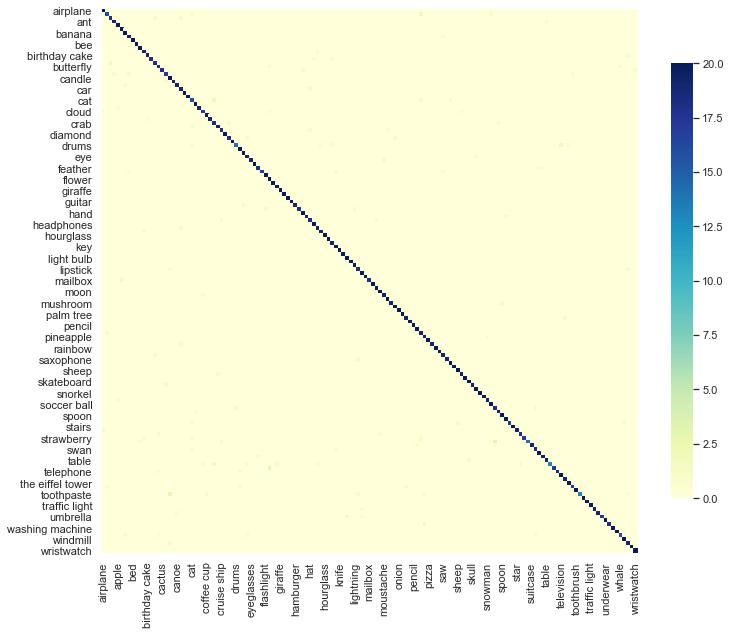

In [31]:
# Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
cm.columns = os.listdir('data/train')
cm.index = os.listdir('data/train')

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    cm, 
    cmap='YlGnBu', 
    linewidths=0,
    #linecolor='gray',
    cbar_kws={"shrink": .8},
    #annot = True,
    fmt='d',
)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right');

### Show predictions on test sample

In [22]:
# Load model
conv_layer = models.alexnet(pretrained=True)
with open("data/classifier.pkl", 'rb') as fid:
    clf_trained = pk.load(fid)

In [23]:
def make_prediction(img):
    features_extracted = conv_layer.features(preprocess(img).reshape((1, 3, 224, 224)))
    conv_layer_output = features_extracted.detach().numpy().reshape((256 * 6 * 6))
    return clf_trained.predict([conv_layer_output])[0]

predicted / actual


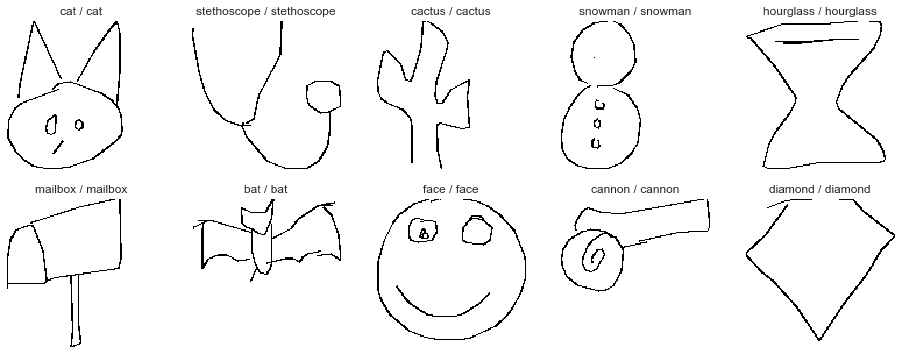

In [24]:
dic_class = {k:v for k,v in zip(range(len(os.listdir(test_dir))),os.listdir(test_dir))}

fig,ax = plt.subplots(figsize=(16,6))

lines=2
cols=5
print('predicted / actual')

# prediction on sample from train dir
for i in range(1,11):
    rd_dir = random.sample(os.listdir(test_dir),1)[0]
    sample = random.sample(os.listdir(test_dir+rd_dir),1)[0]
    im = Image.open(test_dir+rd_dir+'/'+sample)
    predicted_class = make_prediction(im)
    plt.subplot(lines,cols,i)
    plt.imshow(np.asarray(im))
    plt.title('{} / {}'.format(dic_class[predicted_class],rd_dir))
    plt.axis('off')

In [25]:
def make_prediction_proba(img):
    features_extracted = conv_layer.features(preprocess(img).reshape((1, 3, 224, 224)))
    conv_layer_output = features_extracted.detach().numpy().reshape((256 * 6 * 6))
    return clf_trained.predict_proba([conv_layer_output])[0]

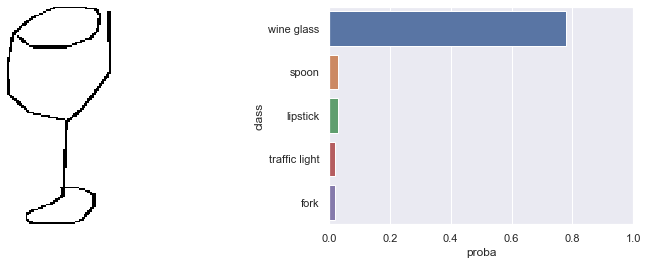

In [64]:
rd_dir = random.sample(os.listdir(test_dir),1)[0]
sample = random.sample(os.listdir(test_dir+rd_dir),1)[0]
im = Image.open(test_dir+rd_dir+'/'+sample)

results = pd.DataFrame({
    'class':list(dic_class.values()),
    'proba':make_prediction_proba(im),
}).sort_values('proba',ascending=False).head()

fig,ax = plt.subplots(figsize=(12,4))

lines=1
cols=2

plt.subplot(lines,cols,1)
plt.imshow(np.asarray(im))
plt.axis('off')

plt.subplot(lines,cols,2)
sns.barplot(data=results, x='proba', y='class')
plt.xlim(0,1);